In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import utilities
from gcn_model import GCNModel
import torch
from sklearn.metrics import confusion_matrix

In [2]:
data_folder = "simulations/splat_0.7_de_rq/"
#data_folder = "/home/groups/ConradLab/daniel/sharp_data/sharp_sims/splat_0.7_de_rq_v3/"
#data_folder = "/home/groups/ConradLab/daniel/sharp_data/pbmc_proto/"
# get labels
data_path = data_folder + "query_counts.csv"
tools = ["sctype","scsorter","scina","singler", "scpred"]
#tools = ["scsorter","scina","singler"]
ref_path = data_folder + "ref_counts.csv"
ref_label_path = data_folder + "ref_labels.csv"
marker_path = data_folder + "markers.txt"
if os.path.exists(data_folder + "preds.csv"):
    all_labels = pd.read_csv(data_folder + "preds.csv", index_col=0)
    if all_labels.shape[1] != len(tools): 
        all_labels = all_labels[tools]
        #raise Exception("wrong amount of tools in file")
else:
    all_labels = utilities.label_counts(data_path,tools,ref_path,ref_label_path,marker_path)

# read in dataset
X = pd.read_csv(data_path, index_col=0)
X, keep_cells,_,_ = utilities.preprocess(np.array(X), scale=False, comps=500)

all_labels = all_labels.loc[keep_cells,:]

_,marker_names = utilities.read_marker_file(marker_path)

all_labels_factored = utilities.factorize_df(all_labels, marker_names)
encoded_labels = utilities.encode_predictions(all_labels_factored)

meta_path = data_folder + "query_meta.csv"
metadata = pd.read_csv(meta_path, index_col=0)
real_y = pd.factorize(metadata['Group'], sort=True)[0]
real_y = real_y[keep_cells]

In [3]:
# get tool weights by cell
confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .9)
train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]
weights = np.zeros((4,5))
for type in [0,1,2,3]:
    
    type_indices = np.where(confident_labels[train_nodes]==type)[0]
    for i, tool in enumerate(tools):
        weights[type,i] = utilities.pred_accuracy(all_labels_factored[tool].to_numpy()[train_nodes][type_indices], confident_labels[train_nodes][type_indices])
weights

array([[1.        , 1.        , 0.95918369, 1.        , 0.81632656],
       [1.        , 1.        , 0.97354496, 1.        , 0.78835976],
       [1.        , 1.        , 0.93129772, 1.        , 0.87022901],
       [1.        , 1.        , 1.        , 1.        , 0.76543212]])

In [6]:
utilities.weighted_encode(all_labels_factored, encoded_labels, weights,.5)

multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes
multiple maxes


array([[0.        , 4.76190472, 0.        , 0.        ],
       [0.        , 2.76190472, 0.        , 2.        ],
       [1.        , 1.97354496, 0.        , 1.78835976],
       ...,
       [0.        , 0.        , 4.80152673, 0.        ],
       [0.        , 1.        , 0.        , 3.76543212],
       [0.        , 3.97354496, 0.        , 0.78835976]])

In [11]:
np.arange(0.01,1,0.1)

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])

In [3]:
thresh = []
conf_acc = []
conf_cells = []
for i in np.arange(0.01,1,0.1):
    thresh.append(i)
    confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = i)
    train_nodes = np.where(confident_labels != -1)[0]
    test_nodes = np.where(confident_labels == -1)[0]
    conf_cells.append(len(train_nodes))
    conf_acc.append(utilities.pred_accuracy(confident_labels[train_nodes], real_y[train_nodes]))


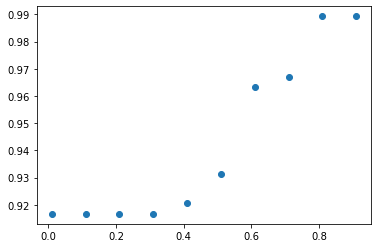

In [4]:
plt.scatter(thresh, conf_acc)

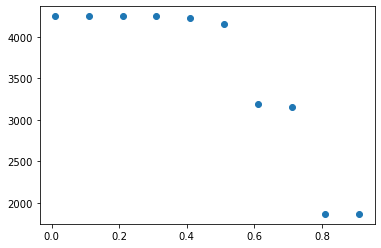

In [5]:
plt.scatter(thresh, conf_cells)

In [6]:
thresh = []
accs = []
for i in np.arange(0.31,1,0.1):
    thresh.append(i)
    confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = i)
    train_nodes = np.where(confident_labels != -1)[0]
    test_nodes = np.where(confident_labels == -1)[0]

    dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

    test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(real_y))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

    m = GCNModel("configs/2_40_5.txt", 2, dropout=0.0)
    m.train(dataloader, 100, verbose=False)

    acc,_,_,_,_,_ = m.validation_metrics(test_dataloader, train_nodes, test_nodes)
    accs.append(acc)

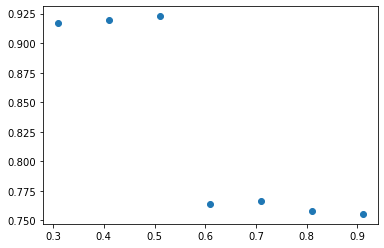

In [7]:
plt.scatter(thresh, accs)

In [8]:
thresh = []
accs = []
for i in np.arange(0.31,1,0.1):
    thresh.append(i)

    # use these as validation set 
    ultra_confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .9)
    ultra_val_nodes = np.where(ultra_confident_labels != -1)[0]

    confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = i)
    confident_labels[ultra_val_nodes] = -1
    train_nodes = np.where(confident_labels != -1)[0]
    test_nodes = np.where(confident_labels == -1)[0]

    dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(confident_labels))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

    test_dataset  = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(ultra_confident_labels))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False)

    m = GCNModel("configs/2_40_5.txt", 2, dropout=0.0)
    m.train(dataloader, 50, verbose=False)

    _,_,acc,_,_,_ = m.validation_metrics(test_dataloader, ultra_val_nodes, test_nodes)
    accs.append(acc)

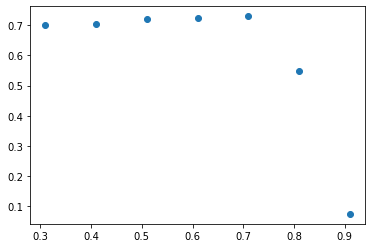

In [9]:
plt.scatter(thresh, accs)

In [8]:
confident_labels = utilities.get_consensus_labels(encoded_labels, necessary_vote = .9)
train_nodes = np.where(confident_labels != -1)[0]
test_nodes = np.where(confident_labels == -1)[0]
confusion_matrix(real_y[train_nodes], confident_labels[train_nodes])

array([[ 49,   0,   0,   0],
       [  0, 189,   0,   0],
       [  0,   0, 131,   0],
       [  0,   0,   0,  81]])

In [9]:
confusion_matrix(real_y[train_nodes], all_labels_factored['sctype'].to_numpy()[train_nodes])

array([[ 49,   0,   0,   0],
       [  0, 189,   0,   0],
       [  0,   0, 131,   0],
       [  0,   0,   0,  81]])

In [10]:
type_indices = np.where(confident_labels[train_nodes]==0)[0]
print(utilities.pred_accuracy(all_labels_factored['scina'].to_numpy()[train_nodes][type_indices], confident_labels[train_nodes][type_indices]))
print(utilities.pred_accuracy(all_labels_factored['scsorter'].to_numpy()[train_nodes][type_indices], confident_labels[train_nodes][type_indices]))
print(utilities.pred_accuracy(all_labels_factored['sctype'].to_numpy()[train_nodes][type_indices], confident_labels[train_nodes][type_indices]))
print(utilities.pred_accuracy(all_labels_factored['singler'].to_numpy()[train_nodes][type_indices], confident_labels[train_nodes][type_indices]))
print(utilities.pred_accuracy(all_labels_factored['scpred'].to_numpy()[train_nodes][type_indices], confident_labels[train_nodes][type_indices]))


0.9591836929321289
1.0
1.0
1.0
0.8163265585899353


In [55]:
for i in np.unique(confident_labels[train_nodes]):
    type_indices = np.where(confident_labels[train_nodes]==i)[0]
    print(utilities.pred_accuracy(all_labels_factored['scina'].to_numpy()[train_nodes][type_indices], real_y[train_nodes][type_indices]))
    break

0.3405994474887848


In [33]:
scores = np.zeros(len(tools))
for i, tool in enumerate(tools):
    scores[i] = utilities.pred_accuracy(all_labels_factored[tool].to_numpy()[train_nodes], confident_labels[train_nodes])
scores

array([0.88786954, 0.87971455, 0.47196737, 0.83792049, 0.73598367])